<a href="https://colab.research.google.com/github/JoseAlbertoSeco/BlablacarCarpooling_DataMining/blob/Patterns/notebooks/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import linear_model
from sklearn import tree 

# Carga de datos

In [ ]:
#!wget https://github.com/JoseAlbertoSeco/MineriaDatos/raw/main/data/processed/df_CLM.csv
#!wget https://github.com/JoseAlbertoSeco/MineriaDatos/raw/main/data/processed/df_Andalucia.csv

## Carga provincial

In [ ]:
andalucia = pd.read_csv("df_andalucia.csv") 
andalucia = andalucia.drop(andalucia.columns[[0]], axis=1)
andalucia.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-01,2017,44,11,es,Albox,Granada,1.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,Si
1,2017-11-03,2017,44,11,es,Albox,Granada,12.0,1,4,1,4,0,Andalucía,Andalucía,Almería,Granada,No,No
2,2017-11-05,2017,44,11,es,Albox,Granada,2.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,No


In [ ]:
clm = pd.read_csv("df_castilla.csv") 
clm = clm.drop(clm.columns[[0]], axis=1)
clm.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-05,2017,44,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
1,2017-11-12,2017,45,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
2,2017-11-19,2017,46,11,es,Albacete,Guadalajara,8.0,1,6,1,6,0,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No


# Label Encoding

Transformamos categorias categóricas en categorias numéricas

## Encoding Andalucia

In [ ]:
andalucia_encoded = andalucia.copy()

In [ ]:
andalucia_encoded['ORIGEN_E'] = andalucia['ORIGEN'].astype('category').cat.codes
andalucia_encoded['DESTINO_E'] = andalucia['DESTINO'].astype('category').cat.codes
andalucia_encoded['PROVINCIA_ORIGEN_E'] = andalucia['PROVINCIA_ORIGEN'].astype('category').cat.codes
andalucia_encoded['PROVINCIA_DESTINO_E'] = andalucia['PROVINCIA_DESTINO'].astype('category').cat.codes
andalucia_encoded['INTERPROVINCIAL_E'] = andalucia['INTERPROVINCIAL'].astype('category').cat.codes
andalucia_encoded['FESTIVO'] = andalucia_encoded['Festivo'].astype('category').cat.codes

In [ ]:
andalucia_encoded.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_E,DESTINO_E,PROVINCIA_ORIGEN_E,PROVINCIA_DESTINO_E,INTERPROVINCIAL_E,FESTIVO
246053,2018-06-08,2018,23,6,es,Mairena del Aljarafe,Corteconcepción,3.0,2,1,1,1,1,Andalucía,Andalucía,Sevilla,Huelva,No,No,296,142,8,4,0,0
246054,2018-07-06,2018,27,7,es,Tomares,Algámitas,4.0,1,1,1,1,0,Andalucía,Andalucía,Sevilla,Sevilla,Si,No,428,25,8,8,1,0


In [ ]:
andalucia_encoded = andalucia_encoded.drop(labels=['ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'], axis=1)


In [ ]:
andalucia_encoded.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN_E,DESTINO_E,PROVINCIA_ORIGEN_E,PROVINCIA_DESTINO_E,INTERPROVINCIAL_E,FESTIVO
0,2017-11-01,2017,44,11,es,1.0,1,1,1,1,0,Si,6,218,0,3,0,1
1,2017-11-03,2017,44,11,es,12.0,1,4,1,4,0,No,6,218,0,3,0,0
2,2017-11-05,2017,44,11,es,2.0,1,1,1,1,0,No,6,218,0,3,0,0


In [ ]:
andalucia_encoded = andalucia_encoded.rename(columns={'ORIGEN_E':'ORIGEN','DESTINO_E':'DESTINO', 'CA_ORIGEN_E':'CA_ORIGEN', 'CA_DESTINO_E': 'CA_DESTINO','PROVINCIA_ORIGEN_E': 'PROVINCIA_ORIGEN','PROVINCIA_DESTINO_E': 'PROVINCIA_DESTINO','INTERPROVINCIAL_E': 'INTERPROVINCIAL'})

In [ ]:
andalucia_encoded.head(2)

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN,DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,FESTIVO
0,2017-11-01,2017,44,11,es,1.0,1,1,1,1,0,Si,6,218,0,3,0,1
1,2017-11-03,2017,44,11,es,12.0,1,4,1,4,0,No,6,218,0,3,0,0


## Encoding Castilla-La Mancha

In [ ]:
clm_encoded = clm.copy()

In [ ]:
# 'ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'
clm_encoded['ORIGEN_E'] = clm['ORIGEN'].astype('category').cat.codes
clm_encoded['DESTINO_E'] = clm['DESTINO'].astype('category').cat.codes
clm_encoded['PROVINCIA_ORIGEN_E'] = clm['PROVINCIA_ORIGEN'].astype('category').cat.codes
clm_encoded['PROVINCIA_DESTINO_E'] = clm['PROVINCIA_DESTINO'].astype('category').cat.codes
clm_encoded['INTERPROVINCIAL_E'] = clm['INTERPROVINCIAL'].astype('category').cat.codes
clm_encoded['FESTIVO'] = clm['Festivo'].astype('category').cat.codes

In [ ]:
clm_encoded.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_E,DESTINO_E,PROVINCIA_ORIGEN_E,PROVINCIA_DESTINO_E,INTERPROVINCIAL_E,FESTIVO
20860,2018-07-14,2018,28,7,es,Guadalajara,Valdelcubo,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,139,4,4,1,0
20861,2018-08-10,2018,32,8,es,Guadalajara,Cobeta,5.0,1,2,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,44,4,4,1,0


In [ ]:
clm_encoded = clm_encoded.drop(labels=['ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'], axis=1)
clm_encoded

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN_E,DESTINO_E,PROVINCIA_ORIGEN_E,PROVINCIA_DESTINO_E,INTERPROVINCIAL_E,FESTIVO
0,2017-11-05,2017,44,11,es,11.0,1,6,1,6,1,No,1,62,0,4,0,0
1,2017-11-12,2017,45,11,es,11.0,1,6,1,6,1,No,1,62,0,4,0,0
2,2017-11-19,2017,46,11,es,8.0,1,6,1,6,0,No,1,62,0,4,0,0
3,2017-12-01,2017,48,12,es,3.0,3,1,1,1,0,No,1,62,0,4,0,0
4,2017-12-10,2017,49,12,es,3.0,1,2,1,2,0,No,1,62,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20857,2018-01-26,2018,4,1,es,3.0,1,1,1,1,0,No,117,34,5,3,0,0
20858,2019-10-11,2019,41,10,es,3.0,1,1,1,1,0,No,117,76,5,5,1,0
20859,2019-09-06,2019,36,9,es,3.0,1,1,1,1,0,No,122,3,1,0,0,0
20860,2018-07-14,2018,28,7,es,3.0,1,1,1,1,0,No,52,139,4,4,1,0


In [ ]:
clm_encoded = clm_encoded.rename(columns={'ORIGEN_E':'ORIGEN','DESTINO_E':'DESTINO', 'CA_ORIGEN_E':'CA_ORIGEN', 'CA_DESTINO_E': 'CA_DESTINO','PROVINCIA_ORIGEN_E': 'PROVINCIA_ORIGEN','PROVINCIA_DESTINO_E': 'PROVINCIA_DESTINO','INTERPROVINCIAL_E': 'INTERPROVINCIAL'})
clm_encoded.head(2)

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN,DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,FESTIVO
0,2017-11-05,2017,44,11,es,11.0,1,6,1,6,1,No,1,62,0,4,0,0
1,2017-11-12,2017,45,11,es,11.0,1,6,1,6,1,No,1,62,0,4,0,0


# Distribución de los datos y preparación de datos

## Castilla-la Mancha

In [ ]:
clm['FESTIVO'] = clm['Festivo'].astype('category').cat.codes
df_clm = clm_encoded.groupby(['DIA', 'ORIGEN','DESTINO','ASIENTOS_OFERTADOS','MES','AÑO','SEMANA','INTERPROVINCIAL']).VIAJES_OFERTADOS.sum()
df_clm = pd.DataFrame(df_clm)
df_clm = df_clm.reset_index()
df_clm.head(2)

,DIA,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,MES,AÑO,SEMANA,INTERPROVINCIAL,VIAJES_OFERTADOS
0,2017-11-01,1,10,13.0,11,2017,44,1,5
1,2017-11-01,1,78,6.0,11,2017,44,0,2


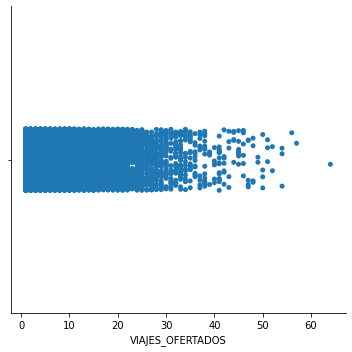

In [ ]:
df_clm.groupby('VIAJES_OFERTADOS').mean()["SEMANA"].plot(kind='bar', figsize=(20,10))

In [ ]:
andalucia.head(2)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-01,2017,44,11,es,Albox,Granada,1.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,Si
1,2017-11-03,2017,44,11,es,Albox,Granada,12.0,1,4,1,4,0,Andalucía,Andalucía,Almería,Granada,No,No


In [ ]:
df_andalucia= andalucia_encoded.groupby(['DIA', 'ORIGEN','DESTINO','ASIENTOS_OFERTADOS','MES','AÑO','SEMANA','INTERPROVINCIAL']).VIAJES_OFERTADOS.sum()
df_andalucia = pd.DataFrame(df_andalucia)
df_andalucia = df_andalucia.reset_index()
df_andalucia.head(2)

                                                                              VIAJES_OFERTADOS
DIA        ORIGEN DESTINO ASIENTOS_OFERTADOS MES AÑO  SEMANA INTERPROVINCIAL                  
2017-11-01 6      218     1.0                11  2017 44     0                               1
           13     157     3.0                11  2017 44     1                               1
           18     29      3.0                11  2017 44     0                               1
                  154     11.0               11  2017 44     1                               4
                  157     6.0                11  2017 44     0                               3
...                                                                                        ...
2019-10-31 484    157     17.0               10  2019 44     0                               7
                  218     32.0               10  2019 44     0                              15
                  237     4.0                10  2

,DIA,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,MES,AÑO,SEMANA,INTERPROVINCIAL,VIAJES_OFERTADOS
0,2017-11-01,6,218,1.0,11,2017,44,0,1
1,2017-11-01,13,157,3.0,11,2017,44,1,1


In [ ]:
df_andalucia.groupby('VIAJES_OFERTADOS').mean()["SEMANA"].plot(kind='bar', figsize=(20,10))

## Feature Selection

In [ ]:
def graph_correlation(corr_matrix):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

  sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
  )

  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 10)


### Castilla-la Mancha

In [ ]:
def correlation_pearson(df):
  corr_matrix = df.corr(method='pearson')
  return corr_matrix

In [ ]:
clm_features_selectec = clm_encoded.copy()
clm_features_selectec.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN,DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,FESTIVO
20860,2018-07-14,2018,28,7,es,3.0,1,1,1,1,0,No,52,139,4,4,1,0
20861,2018-08-10,2018,32,8,es,5.0,1,2,1,1,0,No,52,44,4,4,1,0


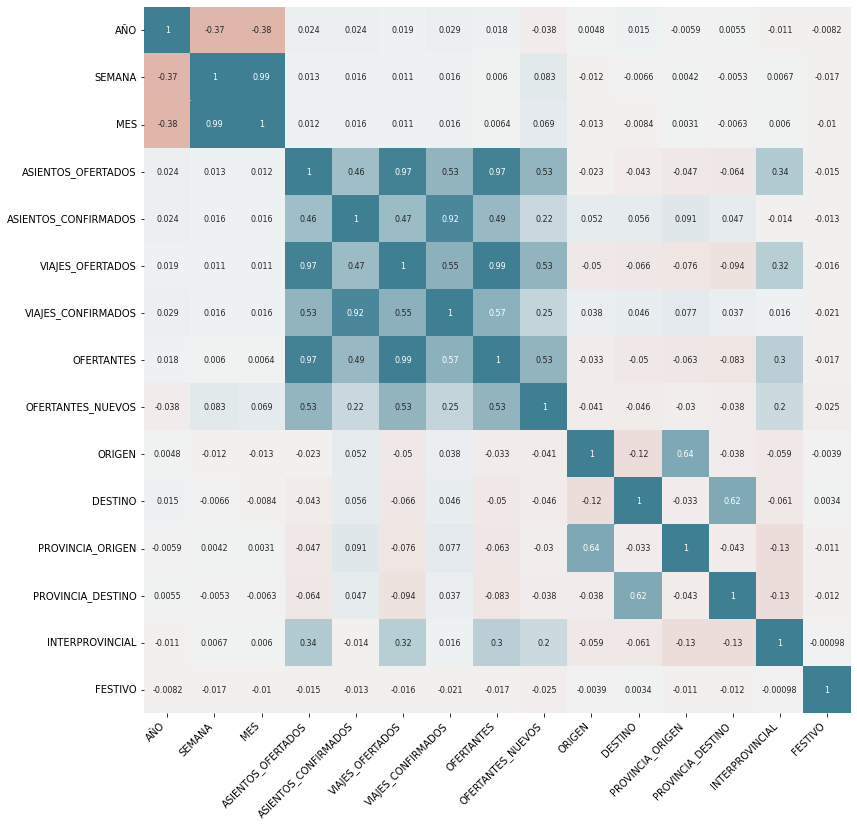

In [ ]:
clm_corr = correlation_pearson(clm_features_selectec)
graph_correlation(clm_corr)

### Andalucia

In [ ]:
andalucia_features_selectec = andalucia_encoded.copy()
andalucia_features_selectec.tail(2)

,DIA,AÑO,SEMANA,MES,PAIS,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,Festivo,ORIGEN,DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,FESTIVO
246053,2018-06-08,2018,23,6,es,3.0,2,1,1,1,1,No,296,142,8,4,0,0
246054,2018-07-06,2018,27,7,es,4.0,1,1,1,1,0,No,428,25,8,8,1,0


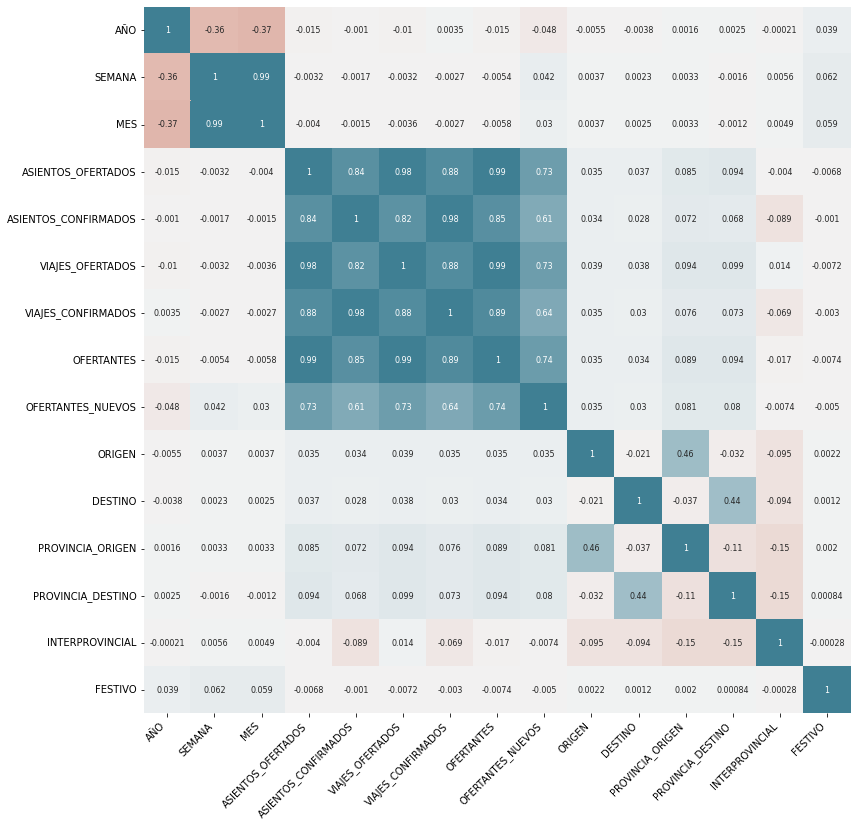

In [ ]:
andalucia_corr = correlation_pearson(andalucia_features_selectec)
graph_correlation(andalucia_corr)

# Modelo de viajes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
import numpy as np

## Random Forest y Decision Tree

In [ ]:
def modelo(df, features_selected, inferir, iterations):
  X = df[features_selected]
  y=df[[inferir]]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)
  print("X_train df\n", X_train.head(3))
  cv = KFold(n_splits = 3, shuffle = True)
  total_scores = []
  for i in range(1,iterations):
        fold_mae = []
        regr = tree.DecisionTreeRegressor(max_depth=i)
        for train_fold, test_fold in cv.split(X_train):
            # División train test aleatoria
            # train
            fx_train = X_train.iloc[train_fold]
            fy_train = y_train.iloc[train_fold]
            # test
            fx_test = X_train.iloc[test_fold]
            fy_test = y_train.iloc[test_fold]

            # entrenamiento y ejecución del modelo
            regr.fit(fx_train, fy_train)
            y_pred = regr.predict(fx_test)
            # evaluación del modelo
            mae = mean_absolute_error(fy_test, y_pred)
            fold_mae.append(mae)
        total_scores.append(sum(fold_mae)/len(fold_mae))
        
  depth = np.argmin(total_scores) + 1
  plt.plot(range(1,len(total_scores)+1), total_scores, 
            marker='o')
  print ('\nMin Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
  plt.ylabel('MAE')      
  plt.legend()
  plt.show()

  regressor = RandomForestRegressor(max_depth = depth, criterion='absolute_error', random_state=2)
  regressor.fit(X_train, y_train)

  # Test
  y_pred = regressor.predict(X_test)

  # metrics calculation 
  
  mae = mean_absolute_error(y_test,y_pred)
  print("Error Measure (MAE) ",  mae)

  xx = np.stack(i for i in range(len(y_test)))
  plt.scatter(xx, y_test, c='r', label='data')
  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.title("RandomForests Regressor")

  plt.show()

  return regressor

### Castilla-la Mancha

In [ ]:
features_selected = ['ORIGEN','MES','SEMANA','AÑO','DESTINO','INTERPROVINCIAL']

X_train df        ORIGEN  MES  SEMANA   AÑO  DESTINO  INTERPROVINCIAL
13476       6    3      10  2019       42                1
15820       1    5      20  2019      135                0
5964       37    6      24  2018      134                0


No handles with labels found to put in legend.



Min Value : 3.2971076346342345 (8)


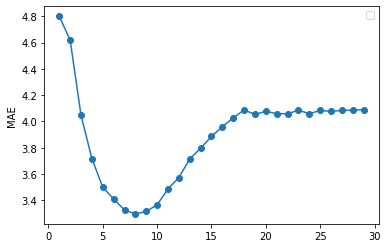

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Error Measure (MAE)  3.0334559024924674


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


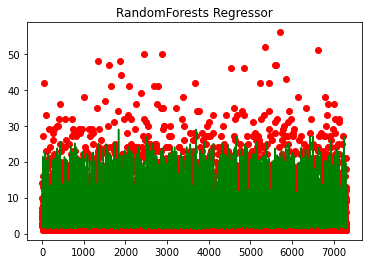

In [ ]:
regressor_clm = modelo(df_clm, features_selected, 'VIAJES_OFERTADOS')

In [ ]:
features_selected = ['ORIGEN','MES','SEMANA','AÑO','DESTINO','INTERPROVINCIAL','VIAJES_OFERTADOS']

X_train df        ORIGEN  MES  SEMANA   AÑO  DESTINO  INTERPROVINCIAL  VIAJES_OFERTADOS
18130      37    2       5  2019        7                1                 6
4012       34    5      18  2018        1                1                 1
12302     118    8      31  2018       42                1                 4


No handles with labels found to put in legend.



Min Value : 2.378542853792244 (8)


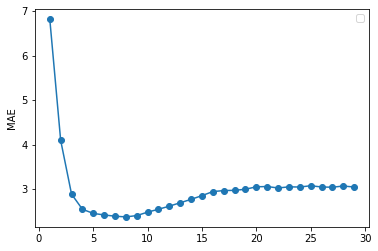

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Error Measure (MAE)  2.255305160568781


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


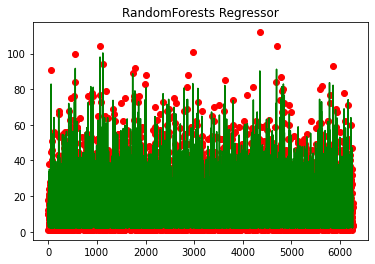

In [ ]:
regressor_clm_asientos = modelo(clm_encoded, features_selected, 'ASIENTOS_OFERTADOS', 20)

### Andalucia

In [ ]:
features_selected = ['ORIGEN','MES','SEMANA','AÑO','DESTINO','INTERPROVINCIAL']

X_train df
         ORIGEN  MES  SEMANA   AÑO  DESTINO  INTERPROVINCIAL
120569     283   12      49  2018      347                0
228269     224    9      38  2019      321                0
70635      188    7      28  2018      157                1


No handles with labels found to put in legend.



Min Value : 6.403526271152399 (9)


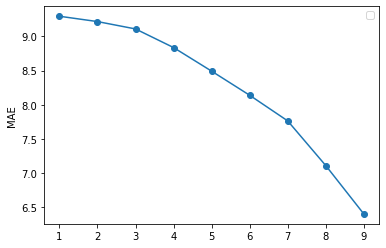

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
regressor_andalucia = modelo(df_andalucia, features_selected, 'VIAJES_OFERTADOS',11)

In [ ]:
features_selected = ['ORIGEN','MES','SEMANA','AÑO','DESTINO','INTERPROVINCIAL','VIAJES_OFERTADOS']

In [ ]:
regressor_asientos_andalucia = modelo(andalucia_encoded, features_selected, 'ASIENTOS_OFERTADOS', 11)

NameError: ignored

# Predicciones

## Predicción para el usuario en Castilla-la Mancha

In [ ]:
orig = clm.ORIGEN.astype('category')
origen_dic = dict(enumerate(orig.cat.categories))

desti = clm.DESTINO.astype('category')
destino_dic = dict(enumerate(desti.cat.categories))

interprovincial_clm = clm.INTERPROVINCIAL.astype('category')
interprovincial_dic_clm =dict(enumerate(interprovincial_clm.cat.categories))

In [ ]:
#@title ORIGEN

origen_clm = 'ciudad' #@param {type:"string"}

origen_clm = list(origen_dic.keys())[list(origen_dic.values()).index(origen_clm)]
origen_clm

Origen:Ciudad Real


In [ ]:
#@title DESTINO

destino_clm = 'ciudad' #@param {type:"string"}
destino_clm = list(destino_dic.keys())[list(destino_dic.values()).index(destino_clm)]
destino_clm

Destino:Valdepeñas


In [ ]:
from datetime import datetime

#@title FECHA DE VIAJE
dia_clm = '2022-01-24' #@param {type:"date"}


date_clm = pd.Timestamp(dia_clm)
mes_clm = date_clm.month

semana_clm = date_clm.week
año_clm = date_clm.year
print(mes_clm,año_clm,semana_clm)

Dia como yyyy-mm-dd:2019-01-16


In [ ]:
dic_caracteristicas_clm = {'ORIGEN':origen_clm, 'DIA':dia_clm, 'MES':mes_clm,'SEMANA':semana_clm, 'AÑO':año_clm,'DESTINO':destino_clm,'INTERPROVINCIAL':0}
df_viaje_clm = pd.DataFrame(dic_caracteristicas_clm, index=[0])
df_viaje_clm = df_viaje_clm.set_index('DIA')
df_viaje_clm

,ORIGEN,MES,SEMANA,AÑO,DESTINO,INTERPROVINCIAL
DIA,,,,,,
2019-01-16,37,1,3,2019,140,0


In [ ]:
pred_clm =  regressor.predict(df_viaje_clm)[0]
print("Viajes que se van a ofertar", pred)

dic_asientos_clm=dic_caracteristicas_clm.copy()
dic_asientos_clm.update({"VIAJES_OFERTADOS":pred})

df_asiento_clm = pd.DataFrame(dic_asientos_clm, index=[0])
df_asiento_clm = df_asiento_clm.set_index('DIA')

asientos_clm = regressor_asientos_clm.predict(df_asiento_clm)
print("Asientos que se van a ofertar", asientos_clm[0])

Viajes que se van a ofertar 4.585
Asientos que se van a ofertar 11.145


## Predicción para el usuario en Castilla-la Mancha

In [ ]:
orig_andalucia = andalucia.ORIGEN.astype('category')
origen_dic_andalucia = dict(enumerate(orig_andalucia.cat.categories))

desti_andalucia = andalucia.DESTINO.astype('category')
destino_dic_andalucia = dict(enumerate(desti_andalucia.cat.categories))

interprovincial_andalucia = andalucia.INTERPROVINCIAL.astype('category')
interprovincial_dic_andalucia =dict(enumerate(interprovincial_andalucia.cat.categories))

In [ ]:
origen_andalucia = input('Origen:')
origen_andalucia = list(origen_dic_andalucia.keys())[list(origen_dic_andalucia.values()).index(origen_andalucia)]
origen_andalucia

Origen:Ciudad Real


In [ ]:
destino_andalucia = input('Destino:')
destino_andalucia = list(destino_dic_andalucia.keys())[list(destino_dic_andalucia.values()).index(destino_andalucia)]
destino_andalucia

Destino:Valdepeñas


In [ ]:
from datetime import datetime
dia_andalucia = input('Dia como yyyy-mm-dd:')

date_andalucia = pd.Timestamp(dia_andalucia)
mes_andalucia = date_andalucia.month

semana_andalucia = date_andalucia.week
año_andalucia = date_andalucia.year
print(mes_andalucia,año_andalucia,semana_andalucia)

Dia como yyyy-mm-dd:2019-01-16


In [ ]:
dic_caracteristicas_andalucia = {'ORIGEN':origen_andalucia, 'DIA':dia_andalucia, 'MES':mes_andalucia,'SEMANA':semana_andalucia, 'AÑO':año_andalucia,'DESTINO':destino_andalucia,'INTERPROVINCIAL':0}
df_viaje_andalucia = pd.DataFrame(dic_caracteristicas_andalucia, index=[0])
df_viaje_andalucia = df_viaje_andalucia.set_index('DIA')
df_viaje_andalucia

,ORIGEN,MES,SEMANA,AÑO,DESTINO,INTERPROVINCIAL
DIA,,,,,,
2019-01-16,37,1,3,2019,140,0


In [ ]:
pred_andalucia =  regressor_andalucia.predict(df_viaje)[0]
print("Viajes que se van a ofertar", pred)

dic_asientos_andalucia=dic_caracteristicas_andalucia.copy()
dic_asientos_andalucia.update({"VIAJES_OFERTADOS":pred_andalucia})

df_asiento_andalucia = pd.DataFrame(dic_asientos_andalucia, index=[0])
df_asiento_andalucia = df_asiento_andalucia.set_index('DIA')

asientos_andalucia = regressor_asientos_andalucia.predict(df_asiento_andalucia)
print("Asientos que se van a ofertar", asientos_andalucia[0])

Viajes que se van a ofertar 4.585
Asientos que se van a ofertar 11.145
